In [42]:
import jax 
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import json
import scipy.sparse
from scipy.sparse.linalg import expm, eigs
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
with open("config.json", "r") as f:
    config = json.load(f)

In [3]:
dt = config["physics"]["time_step"]
temp = 1.0
gamma = 0.1 #jax_md default
sigma_half = gamma*temp

In [4]:
@jax.jit
def pande_potential(x):
    """
    See Example 1 of "Modeling Molecular Kinetics with tICA and the Kernel Trick" 10.1021/ct5007357
    """
    return 4*(x**8+ 0.8*jnp.exp(-80*(x**2)) +  0.2*jnp.exp(-80*((x - 0.5)**2)) + 0.5*jnp.exp(-40*((x + 0.5)**2)))

force = jax.grad(pande_potential)

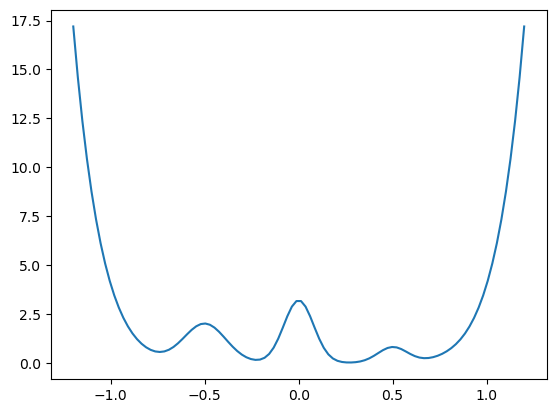

In [5]:
x = jnp.linspace(-1.2, 1.2, 100)
plt.plot(x, jax.vmap(pande_potential)(x))

In [60]:
from discretize import TensorMesh
num = 1000
interval = 2.3
width = interval/num
h = width*np.ones(num)
mesh = TensorMesh([h], origin='C')
mesh.set_cell_gradient_BC('neumann')

[['neumann', 'neumann']]

In [61]:
format = 'csc'
grad_Q = (mesh.average_face_x_to_cell.dot(mesh.cell_gradient_x)).asformat(format)
lap_Q = (grad_Q.dot(grad_Q)).asformat(format)
grad_V = scipy.sparse.diags(np.asarray(jax.vmap(force)(mesh.cell_centers)), format=format)
Q = scipy.sparse.diags(mesh.cell_centers, format=format)

In [62]:
generator = (gamma**-1)*temp*lap_Q - (gamma**-1)*grad_V.dot(grad_Q)

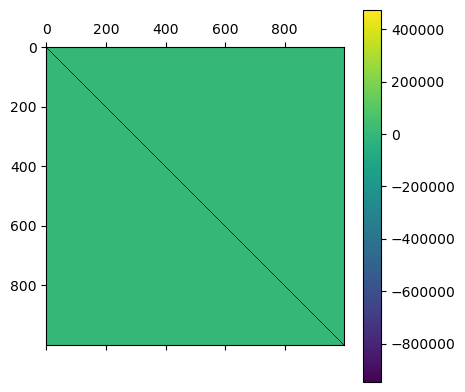

In [63]:
plt.matshow(generator.todense())
plt.colorbar()

In [116]:
vals = np.exp(scipy.linalg.eigvals(dt*100*generator.todense()))
computed_vals = np.load('data/evals_data.npy')[0]
computed_vals_PCR = np.load('data/evals_data_PCR.npy')[0]

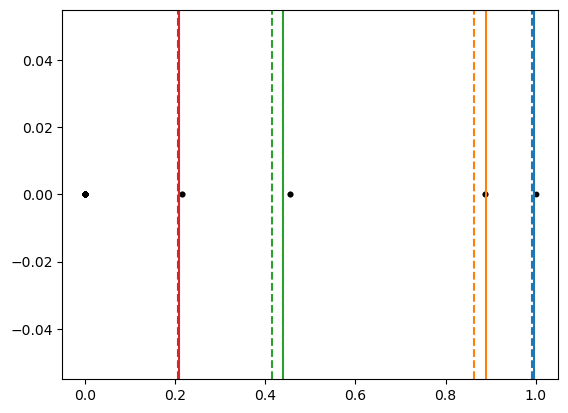

In [117]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.scatter(vals.real, vals.imag, c='k', s=10, marker='o')
for i in range(4):
    plt.axvline(np.mean(computed_vals[:, i].real), c=colors[i])
    plt.axvline(np.mean(computed_vals_PCR[:, i].real), c=colors[i], ls='--')